## OBJECTIVE

### Conducting an A/B Test for a webpage to see if there is a difference in the conversion rate after making some changes in its design. The current conversion rate is roughly 13% and it is expected to grow by 2% = 15%

<b>H0</b>: The two designs perform the same (concerning the conversion rate)

<b>H1</b>: The new design performs better/ worse than the old one (the conversion rate rises/drops)

In [2]:
# Packages imports
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

In [3]:
%matplotlib inline

# Some plot styling preferences
plt.style.use('seaborn-whitegrid')
font = {'family' : 'Helvetica',
        'weight' : 'bold',
        'size'   : 14}

mpl.rc('font', **font)

<b>CALCULATING THE REQUIRED SAMPLE SIZE NEEDED FOR OUR TEST</b>

+ The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.
\
On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.
\
\
So how many people should we have in each group?
\
\
The sample size we need is estimated through something called <b>Power analysis</b>, and it depends on a few factors:


+ <b>Power of the test</b> (1 - beta): This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on statistical power, if you are curious)

+ <b>Significance Level</b> (alpha) - The critical value we set earlier to 0.05
+ <b>Effect size </b>- How big of a difference we expect there to be between the conversion rates

In [4]:
# Calculating effect size based on our expected rates
"""https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/effect-size/"""

effect_size = sms.proportion_effectsize(0.13, 0.15)    

# Calculating sample size needed
required_n = sms.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  

# Rounding up to next whole number
required_n = ceil(required_n)                                                    

print(required_n)

4720


In [5]:
# Laoding the dataset
df = pd.read_csv(r"C:\Users\Prateek\OneDrive\Desktop\ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [8]:
# To see how many users of the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


<b><h4>CHECKING IF ANY USER HAS BEEN SAMPLED MULTIPLE TIMES</h4></b>

In [9]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(f'There are {multi_users} users that appear multiple times in the dataset')

There are 3894 users that appear multiple times in the dataset


In [10]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(f'The updated dataset now has {df.shape[0]} entries')

The updated dataset now has 286690 entries


<b><h4>RANDOM SAMPLING:</h4></b> 
+ Where the number of samples = 4720

In [11]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)

ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,763854,2017-01-21 03:43:17.188315,control,old_page,0
1,690555,2017-01-18 06:38:13.079449,control,old_page,0
2,861520,2017-01-06 21:13:40.044766,control,old_page,0
3,630778,2017-01-05 16:42:36.995204,control,old_page,0
4,656634,2017-01-04 15:31:21.676130,control,old_page,0
...,...,...,...,...,...
9435,908512,2017-01-14 22:02:29.922674,treatment,new_page,0
9436,873211,2017-01-05 00:57:16.167151,treatment,new_page,0
9437,631276,2017-01-20 18:56:58.167809,treatment,new_page,0
9438,662301,2017-01-03 08:10:57.768806,treatment,new_page,0


In [12]:
ab_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9440 entries, 0 to 9439
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       9440 non-null   int64 
 1   timestamp     9440 non-null   object
 2   group         9440 non-null   object
 3   landing_page  9440 non-null   object
 4   converted     9440 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 368.9+ KB


In [13]:
# Counting the values in each group
ab_test['group'].value_counts()

control      4720
treatment    4720
Name: group, dtype: int64

<b><h4>VISUALIZING THE RESULTS</h4></b>

In [22]:
conversion_rates = ab_test.groupby('group')['converted']

# Std. deviation of the proportion
#std_p = lambda x: np.std(x, ddof=0)

# Std. error of the proportion (std / sqrt(n))
#se_p = lambda x: stats.sem(x, ddof=0)            

conversion_rates = conversion_rates.agg([np.mean])#, std_p, se_p])
conversion_rates.columns = ['conversion_rate']#, 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate
group,
control,0.123
treatment,0.126


Judging by the stats above, it does look like the two designs performed <b>very similarly</b>, with our new design performing slightly better, approx. <b>12.3%</b> vs. <b>12.6%</b> <b>conversion rate</b>.

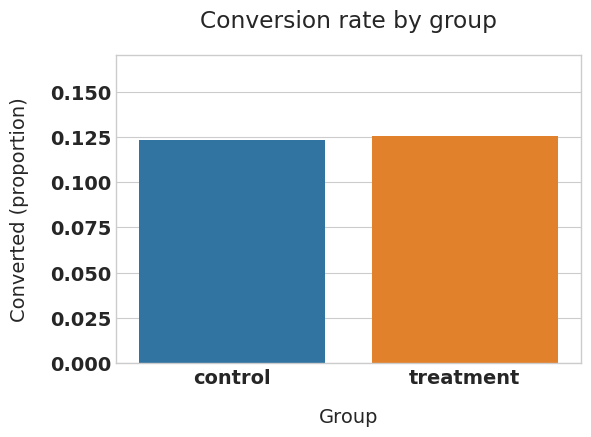

In [25]:
plt.figure(figsize=(6,4))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

<b><h4>TESTING THE HYPOTHESIS</h4></b>

In [26]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

In [27]:
n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

In [28]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

In [29]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -0.34
p-value: 0.732
ci 95% for control group: [0.114, 0.133]
ci 95% for treatment group: [0.116, 0.135]


Since the <b>p-value=0.732</b> is way above our alpha =0.05, we cannot reject the null hypothesis 
, which means that the new design did not perform significantly different (let alone better) than our old one :(

Additionally, if we look at the confidence interval for the treatment group ([0.116, 0.135], i.e. 11.6-13.5%) we notice that:

+ It includes the baseline value of 13% conversion rate
+ It does not include the target value of 15% (the 2% uplift we were aiming for)


What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design.